### MACROS

In [1]:
WEIGHT_DECAY_NAME = 'weight_decay'
LEARNING_RATE_NAME = 'lr'
BATCH_SIZE_NAME = 'BATCH_SIZE'
COLOUR_CHANNELS_NAME = 'COLOUR_CHANNELS'
NO_STACKED_IMGS_NAME = 'NO_STACKED_IMGS'
KEYS_NAME = 'KEYS'


### IMPORTS

In [2]:
# !pip install albumentations

In [3]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

# import monai
# # monai.config.print_config()

from monai.apps import DecathlonDataset
from monai.data import DataLoader, CacheDataset, decollate_batch
# # from monai.data import decollate_patient_batch
# from monai.utils import first, set_determinism
from monai.networks.nets import UNet, DynUNet, AttentionUnet, ViTAutoEnc, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, MeanIoU, compute_average_surface_distance, DiceHelper
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
# import albumentations as A
from monai.transforms import (
    LoadImage,
    LoadImageD,
    EnsureChannelFirstD,
#     AddChannelD,
    ScaleIntensityD,
    ToTensorD,
    Compose,
    AsDiscreteD,
    SpacingD,
    OrientationD,
    ResizeD,
    RandAffineD,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensity,
    ResizeD,
    RandAffineD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
#     RandDeformD,
    ToTensorD,
    Activations, AsDiscrete
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as TorchDataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import sys
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import yaml

import nibabel as nib

from torch.utils.data.dataloader import default_collate

# from hyperparams import *


In [4]:
from torch.utils.tensorboard import SummaryWriter


### HYPERPARAMS ###


In [6]:
config_path = './config.yaml'

with open("config.yaml", "r") as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [7]:
config

{'BATCH_SIZE': 16,
 'COLOUR_CHANNELS': 1,
 'KEYS': ['image', 'label'],
 'LEARNING_RATE': 0.03,
 'MAX_EPOCHS': 10,
 'NO_STACKED_IMGS': 6,
 'UNet_metadata': {'channels': (16, 32, 32, 128),
  'dropout': 0.1,
  'in_channels': 1,
  'kernel_size': (5, 5, 5),
  'norm': 'BATCH',
  'num_res_units': 4,
  'out_channels': 2,
  'spatial_dims': 3,
  'strides': (1, 1, 1)},
 'VALIDATION_INTERVAL': 2,
 'decayRate': 0.96}

In [23]:
BATCH_SIZE = 16

COLOUR_CHANNELS = config[COLOUR_CHANNELS_NAME]
NO_STACKED_IMGS = config[NO_STACKED_IMGS_NAME]

KEYS = config[KEYS_NAME]

In [24]:
### HYPERPARAMS ###
crt_dir = os.getcwd()
datasets_path = f'./datasets/Trimmed_MSD/'

model_name = 'unet'
checkpoints_path = f'{crt_dir}/checkpoints/{model_name.upper()}/'

DEBUG_MODE = True


### MAIN ###

In [25]:
# Initialize torch and cuda
cuda = torch.cuda.is_available()

# Set device to 3rd GPU
# device = torch.device("cuda:2" if cuda else "cpu")

# Use all GPUs
device = torch.device("cuda" if cuda else "cpu")

print(f'You are using {device}')

print(f'Number of images in a stack: {NO_STACKED_IMGS}')

You are using cuda
Number of images in a stack: 6


In [26]:
device

device(type='cuda')

In [27]:
# Used to bypass this error: https://github.com/pytorch/pytorch/issues/113245
os.environ["CUDA_VISIBLE_DEVICES"]="2,1,0" # "3,2,1,0";  "2, 3"

In [28]:
os.environ["CUDA_VISIBLE_DEVICES"]

'2,1,0'

In [29]:
# torch.multiprocessing.set_start_method('spawn', force=True)

In [30]:
# Set random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# DEBUG FUNCTIONALITIES

In [31]:
from seg_src.debug_utils import debug_plot_single, debug_plot, plot_prediction_label_side_by_side

### PREPROCESSING TRANSFORMS

In [32]:
# Used Dictionary transforms from MONAI to apply the same transforms to both the image and the label
train_transform = Compose([RandRotateD(range_x=0, range_y=0, range_z=np.pi/12, prob=1, keys=['image', 'label'])])
post_pred = Compose([AsDiscrete(argmax=True, to_onehot= 2)])

# DATA LOADER

In [33]:
from seg_src.datasets import msdDatasetTrain, msdDatasetEvaluation, msdDatasetTest

In [34]:
train_name = "training/"
dev_name = "dev/"
val_name = "validation/"
test_name = "test/"

In [35]:
datasets_path

'./datasets/Trimmed_MSD/'

In [36]:
"Batch size: ", BATCH_SIZE

('Batch size: ', 16)

In [37]:
msd_train_dataset = msdDatasetTrain(datasets_path + train_name, transform = train_transform, tumour_percent_threshold=0.125, samples_proportion=0.7, undersample_flag=True, undersample_size=622) #undersample_size=460)

training


./ordered_overlapping_training_indices_stack=6.pkl does not exist. Building the ordered indices.


63it [00:24,  2.56it/s]


./training_indices_stack=6_samples0.7_batches0.5_undersample=True_size=460.pkl does not exist. Building the overall indices.
Small tumour stacks 2901
Small tumour stacks2 460
Big tumour stacks 1185
Oversampling factor 1
Keep undersample indices 1073
Big tumour stacks2 1073
Length of small tumour stacks 456
Length of big tumour stacks 1072
Length of the dataset 912


In [38]:
msd_dev_dataset = msdDatasetEvaluation(datasets_path + dev_name)

validation
./ordered_nonoverlapping_validation_indices_stack=6.pkl does not exist. Building the ordered indices.


In [39]:
# Train dataset ar trebui sa fie in jur de 912
len(msd_train_dataset), len(msd_dev_dataset)

(912, 56)

  0%|          | 0/912 [00:00<?, ?it/s]

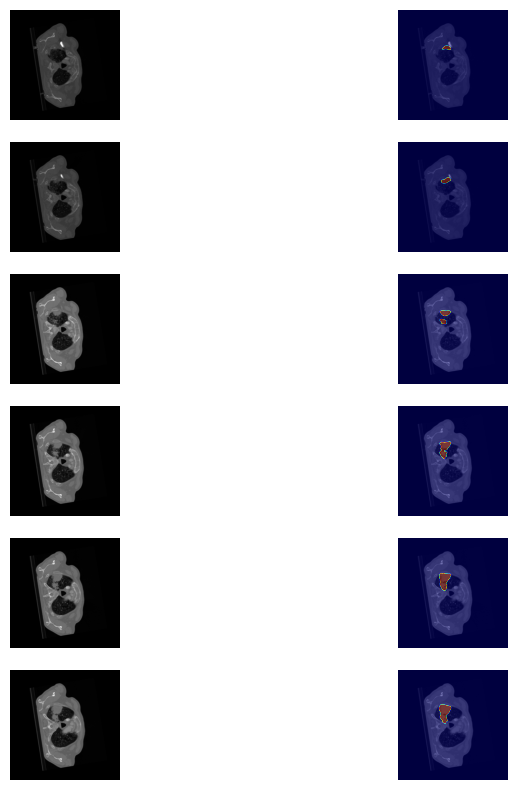

  0%|          | 1/912 [00:00<13:33,  1.12it/s]

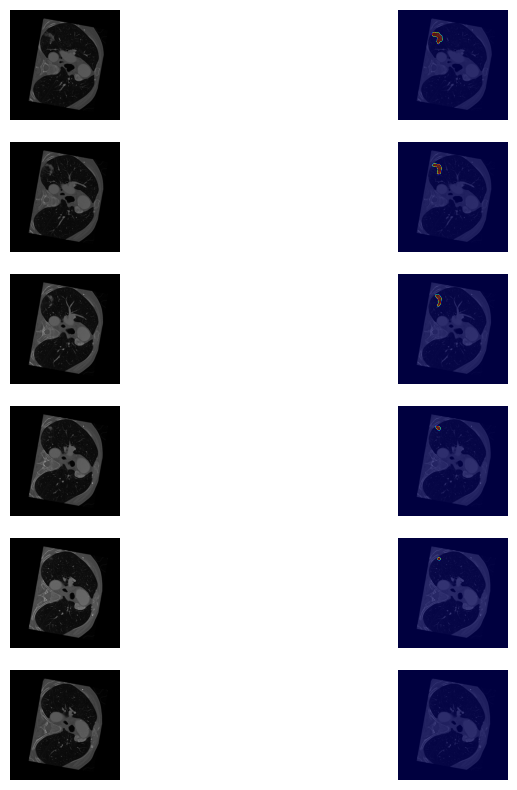

  0%|          | 1/912 [00:01<28:57,  1.91s/it]


In [40]:
for i in tqdm(range(len(msd_train_dataset))):
    img, label = msd_train_dataset[i]
    
    debug_plot(img, label)

    if i >= 1:
        break

    if img.max() == 0:
        print("Dataset is corrupted")
        break

  0%|          | 0/56 [00:00<?, ?it/s]

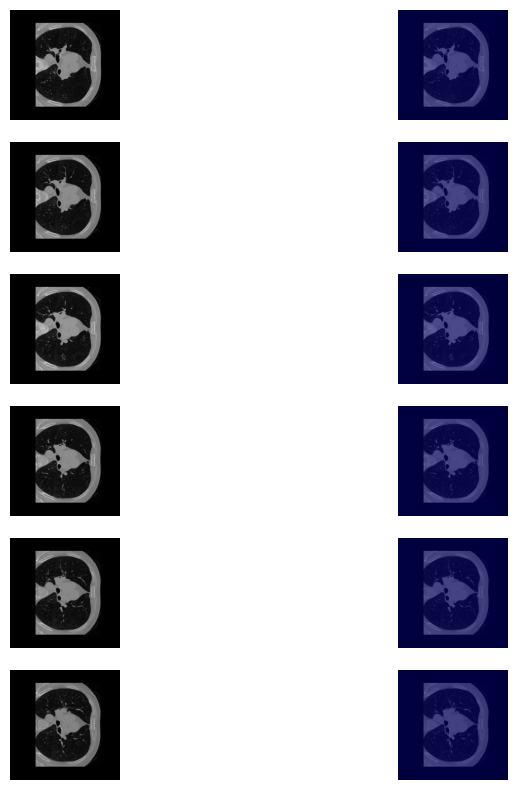

  2%|▏         | 1/56 [00:00<00:34,  1.57it/s]

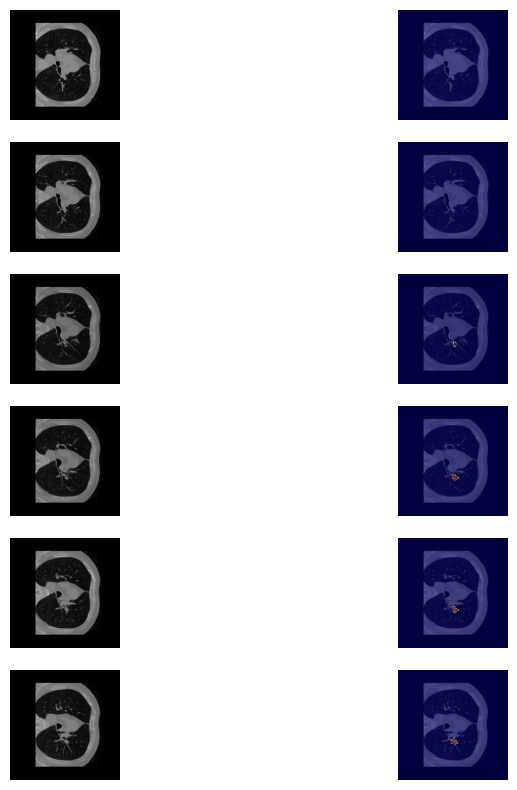

  2%|▏         | 1/56 [00:01<01:12,  1.32s/it]


In [41]:
for i in tqdm(range(len(msd_dev_dataset))):
    img, label = msd_dev_dataset[i]
    
    debug_plot(img, label)

    if i >= 1:
        break

    if img.max() == 0:
        print("Dataset is corrupted")
        break

In [42]:
msd_val_dataset = msdDatasetEvaluation(datasets_path + val_name, transform = None)

validation
./ordered_nonoverlapping_validation_indices_stack=6.pkl exists. Loading the ordered indices.


  0%|          | 0/56 [00:00<?, ?it/s]

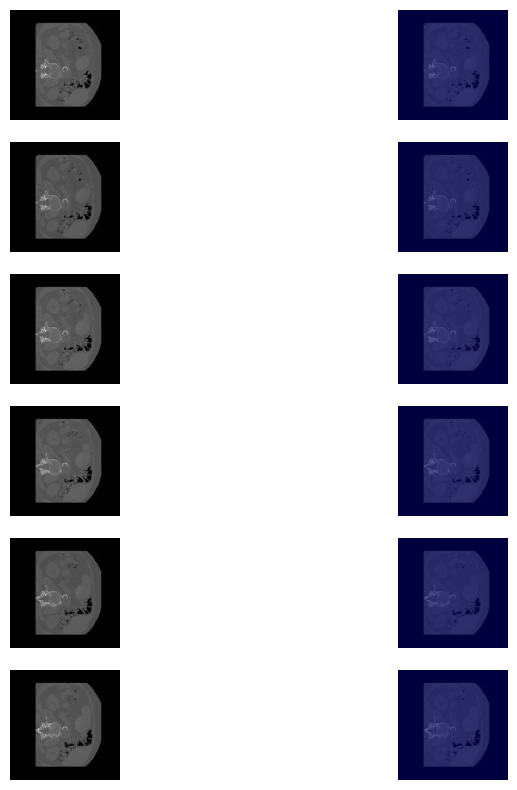

  2%|▏         | 1/56 [00:00<00:40,  1.34it/s]

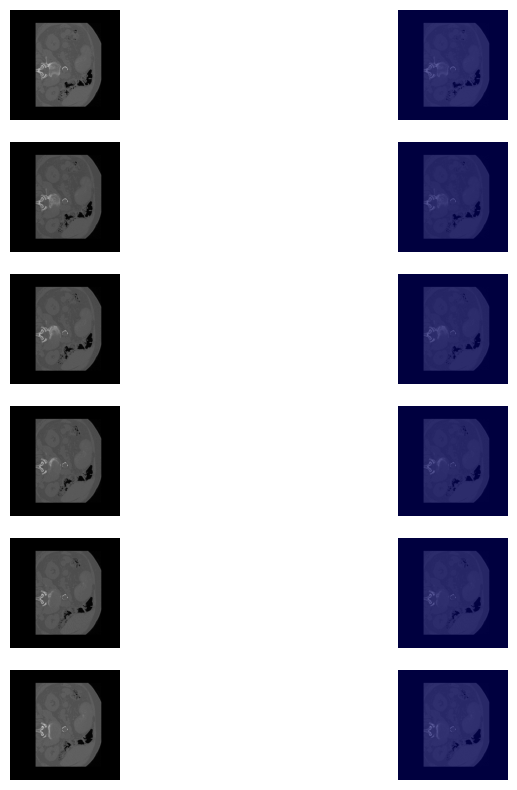

  2%|▏         | 1/56 [00:01<01:15,  1.37s/it]


In [43]:
for i in tqdm(range(len(msd_val_dataset))):
    img, label = msd_val_dataset[i]
    
    debug_plot(img, label)

    if i >= 1:
        break

    if img.max() == 0:
        print("Dataset is corrupted")
        break

In [44]:
len(msd_train_dataset), len(msd_val_dataset)

(912, 56)

In [45]:
train_loader = TorchDataLoader(msd_train_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn=lambda x: tuple(x_ for x_ in default_collate(x))) # TODO: Comment collate_fn if it doesn't work
dev_loader = TorchDataLoader(msd_dev_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn=lambda x: tuple(x_ for x_ in default_collate(x))) # TODO: Comment collate_fn if it doesn't work

In [46]:
for img, label in tqdm(train_loader):
    break

    # no_healthy, no_ill = 0, 0

    # for i in range(BATCH_SIZE):
    #     if torch.sum(label[i, 0, ...]) > 1e-5:
    #         no_ill += 1
    #     else:
    #         no_healthy += 1

    # print("Healthy", no_healthy, "Ill", no_ill)




  0%|          | 0/57 [00:02<?, ?it/s]


In [47]:
for img, label in tqdm(dev_loader):
    break

  0%|          | 0/4 [00:00<?, ?it/s]


In [48]:
val_loader = TorchDataLoader(msd_val_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn=lambda x: tuple(x_ for x_ in default_collate(x))) #  num_workers = num_workers,

for _ in tqdm(val_loader):
    break

  0%|          | 0/4 [00:00<?, ?it/s]


In [49]:
debug_img, debug_label = next(iter(train_loader))

In [50]:
debug_img.shape, debug_label.shape

(torch.Size([16, 1, 512, 512, 6]), torch.Size([16, 1, 512, 512, 6]))

In [51]:
input_channels = debug_img.shape[1]
output_channels = 2*input_channels

In [52]:
debug_img, debug_label = debug_img.to(device), debug_label.to(device)

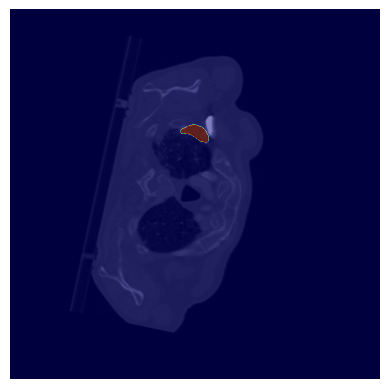

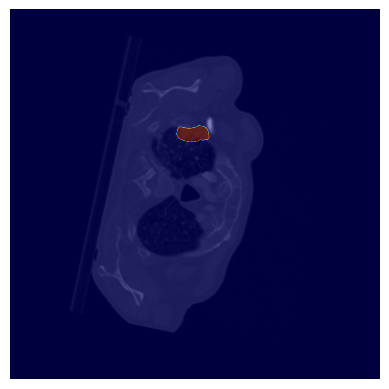

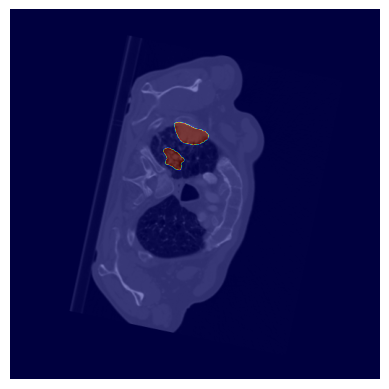

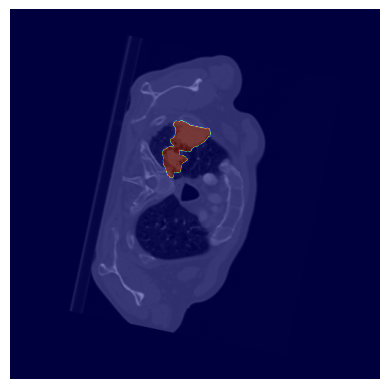

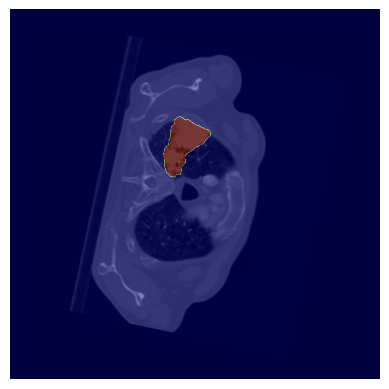

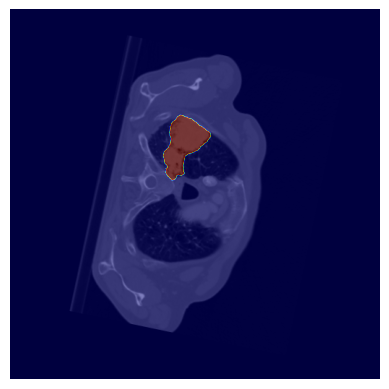

In [53]:
debug_plot_single(debug_img, debug_label)

## MODEL

In [54]:
from seg_src.train import  save_checkpoint, load_checkpoint, train

### MODEL HYPERPARAMS ###


In [55]:
# 100 EPOCHS:
UNet_metadata = dict(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 2,
    channels = (16, 32, 32, 128),
    kernel_size = (5, 5, 5),
    strides = (1, 2, 1, 2),
    num_res_units = 4,
    norm = Norm.BATCH,
    # act = torch.nn.ReLU,
    dropout = 0.1
)

# UNet_metadata = dict(
#     spatial_dims = 3,
#     in_channels = 1,
#     out_channels = 2,
#     channels = (16, 32, 128, 128),
#     kernel_size = (5, 5, 5),
#     strides = (1, 2, 1),
#     num_res_units = 4,
#     norm = Norm.BATCH,
#     # act = torch.nn.ReLU,
#     dropout = 0.1
# )


In [56]:
# Search available gpu devices for nn.DataParallel



In [57]:
# # Instantiate model
net = nn.Sequential(nn.BatchNorm3d(1, affine=True), UNet(**UNet_metadata), nn.InstanceNorm3d(2, affine=True))

net = nn.DataParallel(net)# device_ids = [0, 1, 2, 3]
net = net.to(device)


# Xavier initialization
for name, param in net.named_parameters():
    if isinstance(param, nn.Linear):
        nn.init.xavier_normal_(param)
    elif 'bias' in name:
        nn.init.constant_(param, 0.05)




In [58]:
# net.state_dict()

In [59]:
debug_img.shape

torch.Size([16, 1, 512, 512, 6])

In [60]:
net(debug_img).shape

torch.Size([16, 2, 512, 512, 6])

In [61]:
### LOSS ###
loss_functions = {
    'dice': DiceLoss(to_onehot_y = True, softmax = True, include_background=False),
    'cross_entropy': nn.CrossEntropyLoss(),
    'custom': nn.BCELoss()
}

loss_key = 'dice'

loss_function = loss_functions[loss_key]


In [62]:
epoch_offset = 0

In [63]:
LEARNING_RATE = 5e-3
wd = 1e-4

In [64]:
optimizers = { 'adam' : torch.optim.Adam, 'sgd' : torch.optim.SGD, 'nadam' : torch.optim.NAdam, 'rmsprop' : torch.optim.RMSprop, 'adamw' : torch.optim.AdamW}
optimizer_key = 'nadam'

# Instantiate optimizer
decayRate = 1  #- 1e-3
optimizer = optimizers[optimizer_key](net.parameters(), lr = LEARNING_RATE, weight_decay = wd)

# Instantiate learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)


In [65]:
### PERFORMANCE METRICS ###
dice_metric = DiceHelper(include_background = False, reduction = "mean", get_not_nans=False, ignore_empty=True) # include_background = False,
iou_metric = MeanIoU(include_background=False, reduction = "mean", get_not_nans=False, ignore_empty=True)

In [66]:
# best_previous_model_name = './checkpoints/UNET/min-max_augmented_unet_nadam_lr5.00e-03_wd1.00e-03_diceloss_epoch82.pth'
# net, optimizer, epoch_offset, loss_function = load_checkpoint(best_previous_model_name, net, optimizer)

### TRAINING PROCEDURE ###

In [67]:
best_model_name = train(net, checkpoints_path, 'UNET',
                        loss_function, loss_key, lr_scheduler,
                        optimizer, optimizer_key, device,
                        msd_train_dataset, train_loader, val_loader,
                        MAX_EPOCHS = 100, VALIDATION_INTERVAL = 2, EPOCH_OFFSET = epoch_offset)

/home/aimas/Desktop/Hackathon_Enfield/checkpoints/UNET/xoxo_nadam_lr5.00e-03_wd1.00e-04_diceloss_best.pth
------------
Epoch 1/2
1/57, train_loss: 0.9919
2/57, train_loss: 0.9880
3/57, train_loss: 0.9877
4/57, train_loss: 0.9876
5/57, train_loss: 0.9878
6/57, train_loss: 0.9924
7/57, train_loss: 0.9903
8/57, train_loss: 0.9841
9/57, train_loss: 0.9909
10/57, train_loss: 0.9869
11/57, train_loss: 0.9846
12/57, train_loss: 0.9896
13/57, train_loss: 0.9931
14/57, train_loss: 0.9826
15/57, train_loss: 0.9803
16/57, train_loss: 0.9925
17/57, train_loss: 0.9868
18/57, train_loss: 0.9885
19/57, train_loss: 0.9901
20/57, train_loss: 0.9887
21/57, train_loss: 0.9805
22/57, train_loss: 0.9862
23/57, train_loss: 0.9867
24/57, train_loss: 0.9869
25/57, train_loss: 0.9864
26/57, train_loss: 0.9853
27/57, train_loss: 0.9828
28/57, train_loss: 0.9811
29/57, train_loss: 0.9940
30/57, train_loss: 0.9846
31/57, train_loss: 0.9852
32/57, train_loss: 0.9788
33/57, train_loss: 0.9759
34/57, train_loss: 0.9

RuntimeError: Parent directory /home/aimas/Desktop/Hackathon_Enfield/checkpoints/UNET does not exist.

In [ ]:
# Get net weights
net.state_dict()

OrderedDict([('module.0.weight', tensor([2.7086], device='cuda:0')),
             ('module.0.bias', tensor([-2.6364], device='cuda:0')),
             ('module.0.running_mean', tensor([0.0936], device='cuda:0')),
             ('module.0.running_var', tensor([0.0222], device='cuda:0')),
             ('module.0.num_batches_tracked', tensor(7202, device='cuda:0')),
             ('module.1.model.0.conv.unit0.conv.weight',
              tensor([[[[[-1.3610e+00, -1.5060e+00, -1.5565e+00, -1.7120e+00, -1.0947e+00],
                         [-1.5758e+00, -1.7798e+00, -1.9167e+00, -2.0562e+00, -1.3390e+00],
                         [-1.8840e+00, -2.1444e+00, -2.3577e+00, -2.4360e+00, -1.6384e+00],
                         [-2.1715e+00, -2.4633e+00, -2.7158e+00, -2.7522e+00, -1.9127e+00],
                         [-2.4082e+00, -2.7130e+00, -2.9870e+00, -2.9984e+00, -2.1297e+00]],
              
                        [[-1.4092e+00, -1.6378e+00, -1.7406e+00, -1.9011e+00, -1.2605e+00],
           

In [ ]:
best_model_name

NameError: name 'best_model_name' is not defined

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard

%tensorboard --logdir=./pytorch_logging/unet_adam_lr3.00e-03_diceloss_epochs50/

### VALIDATION PROCEDURE ###

In [ ]:
val_name = './checkpoints/UNET/min-max3_augmented_unet_nadam_lr5.00e-04_wd1.00e-03_diceloss_epoch2.pth'

In [ ]:
val_net = net

In [ ]:
# TODO: Verificat dupa ce rezolv restul lucrurilor de ce nu merge loadul ca lumea
val_net = nn.Sequential(nn.BatchNorm3d(1, affine=True), UNet(**UNet_metadata), nn.InstanceNorm3d(2, affine=True))
val_net = nn.DataParallel(val_net, device_ids = [0, 1, 2, 3])
val_net = val_net.to(device)
val_net.load_state_dict(torch.load(val_name))


In [ ]:
# IDIOT PROOF "IT WORKS WELL" TEST - VALIDATION LOADER #
for val_data1 in val_loader:
    val_input1, val_label1 = val_data1
    break

they_are_ordered = True

for i in range(val_input1.shape[0]):
    they_are_ordered &= (val_input1[i] == msd_val_dataset[i][0]).all()

print(f"Same order test1: {they_are_ordered}")

i = 3
skipped_images = 0
for val_data2 in val_loader:
    if i > 0:
        i -= 1
        skipped_images += val_data2[0].shape[-1]
        continue
    else:
        val_input2, val_label2 = val_data2
        break

print(f"No of skipped images: {skipped_images}")
for j in range(3*val_input2.shape[0], 4*val_input2.shape[0]):
    print("Index of image in batch: ", j % val_input2.shape[0], " || ", "Index of image in dataset: ", j)
    
    they_are_ordered &= (val_input2[j % val_input2.shape[0]] == msd_val_dataset[j][0]).all()

    # for idx in range(6):
    #     fig, ax = plt.subplots(1, 2)
    #     ax[0].imshow(val_input2[j % val_input2.shape[0]][0, ..., idx])
    #     ax[1].imshow(msd_val_dataset[j][0][0, ..., idx])
    #     plt.show()

    

print(f"Same order test2: {they_are_ordered}")

Same order test1: True
No of skipped images: 18
Index of image in batch:  0  ||  Index of image in dataset:  48
Index of image in batch:  1  ||  Index of image in dataset:  49
Index of image in batch:  2  ||  Index of image in dataset:  50
Index of image in batch:  3  ||  Index of image in dataset:  51
Index of image in batch:  4  ||  Index of image in dataset:  52
Index of image in batch:  5  ||  Index of image in dataset:  53
Index of image in batch:  6  ||  Index of image in dataset:  54
Index of image in batch:  7  ||  Index of image in dataset:  55
Index of image in batch:  8  ||  Index of image in dataset:  56
Index of image in batch:  9  ||  Index of image in dataset:  57
Index of image in batch:  10  ||  Index of image in dataset:  58
Index of image in batch:  11  ||  Index of image in dataset:  59
Index of image in batch:  12  ||  Index of image in dataset:  60
Index of image in batch:  13  ||  Index of image in dataset:  61
Index of image in batch:  14  ||  Index of image in 

In [ ]:
# IDIOT PROOF "IT WORKS WELL" TEST - LR SCHEDULER LOADER #
future_lr1 = lr_scheduler.get_last_lr()[0] * decayRate

lr_scheduler.step()
future_lr2 = lr_scheduler.get_last_lr()[0]

print(f"LR works as expected: {future_lr1 == future_lr2}")

LR works as expected: True


In [ ]:
qualitative_plots_flag = False
save_qualitative_plots_flag = False

In [ ]:
### PERFORMANCE METRICS ###
dice_metric_eval = DiceHelper(include_background = False, reduction = "mean", get_not_nans=False, ignore_empty=True) # include_background = False,
iou_metric_eval = MeanIoU(include_background=False, reduction = "mean", get_not_nans=False, ignore_empty=True)

In [ ]:
if save_qualitative_plots_flag:
    if not os.path.exists('./plots'):
        os.mkdir('./plots')
        os.mkdir(f'./plots/{model_name.upper()}')
        os.mkdir(f'./plots/{model_name.upper()}/images')
        os.mkdir(f'./plots/{model_name.upper()}/gifs')

    if not os.path.exists(f'./plots/{model_name.upper()}'):
        os.mkdir(f'./plots/{model_name.upper()}')
        os.mkdir(f'./plots/{model_name.upper()}/images')
        os.mkdir(f'./plots/{model_name.upper()}/gifs')


In [ ]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)

    if total_pixel_truth == 0:
        if np.sum(pred_mask) == 0:
            return 1
        else:
            return 0

        
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [ ]:
import torchvision


shrinker = torchvision.transforms.Resize((128, 128), interpolation=2)


def compress_volume(shrinker, image):
    '''Compresses the volume to 128x128xDepth'''

    compressed_volume = torch.zeros((image.shape[0], image.shape[1], 128, 128, image.shape[-1]))
#     print(compressed_volume.shape)
#     print(image[0, 0, ..., 0].shape)
#     print(shrinker(image[0, 0, ..., 0].unsqueeze(0)).squeeze().shape)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[-1]):
                compressed_volume[i, j, ..., k] = shrinker(image[i, j, ..., k].unsqueeze(0)).squeeze()

    return compressed_volume.to(device)


debug_label = torch.rand((16, 2, 512, 512, 6))

compress_volume(shrinker, debug_label).shape

torch.Size([16, 2, 128, 128, 6])

In [ ]:
no_val_iters = 0
loss_val = []
dice_val = []
iou_val = []
precision_val = []
recall_val = []

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

save_val_data = []

with torch.no_grad():
    val_net.eval()

    count_plots = 0
    idx = 0

    for batch in val_loader:
        val_img, val_label = batch
        val_img, val_label = val_img.to(device), val_label.to(device)

        val_output = val_net(val_img)
        val_output = nn.Softmax(dim=1)(val_output)

        # Shrink to 128x128 both val_output and val_label
        val_output = compress_volume(shrinker, val_output)
        val_label = compress_volume(shrinker, val_label)
        


        # roi_size = (512, 512, 2)
        # sw_batch_size = 1
        # val_outputs_dice = sliding_window_inference(val_img, roi_size, sw_batch_size, val_net)

        # val_outputs_dice = []
        # for val_crt_output in decollate_batch(val_outputs_dice):
        #     print(val_crt_output == None)
        #     print(val_crt_output.shape)
        #     val_outputs_dice.append(post_pred(nn.Softmax(dim=1)(val_crt_output)))

        # val_label_dice = []
        # for crt_label in decollate_batch(val_label):
        #     val_label_dice.append(post_label(crt_label))

        # compute metric for current iteration
        dice_val.append(dice_metric_eval(y_pred=val_output, y=val_label).item())
        # dice_val.append(dice_coef(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        # precision_val.append(precision_score_(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        # recall_val.append(recall_score_(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        # iou_val.append(iou(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        iou_metric_eval(y_pred=val_output, y=val_label)
        # print("Dice score : ", dice_metric_eval.aggregate().item())
        # print("IoU score : ", iou_metric_eval.aggregate().item())
        # print("Loss : ", loss_function(val_output, val_label).item())

        # dice_val.append(dice_metric_eval.aggregate().item())
        # loss_val.append(loss_function(val_output, val_label).item())
        # iou_val.append(iou_metric_eval.aggregate().item())
        # no_val_iters += 1


        # if recall_val[-1] > 0.8:
        #     save_val_data.append((val_img, val_label, val_output, recall_val[-1]))
        

        if qualitative_plots_flag:
            plot_prediction_label_side_by_side(val_img, val_label, val_output, threshold = 0.5)
            break

        if save_qualitative_plots_flag:

            for i in range(val_img.shape[0]):

                if idx == len(msd_val_dataset):
                    sys.exit()

                print(f"Current index: {idx} / {len(msd_val_dataset)}")
                # Don't save images for the padding indices
                # Only iterate through the unique slices for each patient
                patient_id, slices = msd_val_dataset.stacks_in_order_indices[idx]
                slices = np.unique(slices)
                
                if patient_id > 0:
                    sys.exit()

                im = val_img[i].to('cpu').detach().numpy()
                target = val_label[i].to('cpu').detach().numpy()
                output = val_output[i].to('cpu').detach().numpy()

                # Normalize the output to 0 or 1
                # output = hard_threshold_labels(output)

                idx += 1
                for j in range(len(slices)):
                    plt.imshow(im[0, ..., j], cmap = 'gray')
                    plt.imshow(output[1, ..., j], cmap = 'jet', alpha = 0.5)
                    plt.gca().set_axis_off()

                    plt.savefig(f'./plots/{model_name.upper()}/images/patient{patient_id}_slice{slices[j]}.png')
                    plt.close()

    # Aggregate the final mean results
    dice_score_eval = torch.mean(torch.tensor(dice_val)).item()
    mean_iou_eval = iou_metric_eval.aggregate().item()
    # mean_iou_eval = torch.mean(torch.tensor(iou_val)).item()
    p_score_eval = np.mean(precision_val)
    r_score_eval = np.mean(recall_val)


    # # Reset the status
    # dice_metric_eval.reset()
    # iou_metric_eval.reset()

    print(f"Evaluation metrics: dice: {dice_score_eval:.4f}, iou: {mean_iou_eval:.4f}, precision: {p_score_eval:.4f}, recall: {r_score_eval:.4f}")

Evaluation metrics: dice: 0.0032, iou: 0.0033, precision: nan, recall: nan


In [ ]:

for (val_img, val_label, val_output, crt_recall) in save_val_data:
    
    print(f'Recall score: {crt_recall}')
    for i in range(val_img.shape[-1]):
        im = val_img[0].to('cpu').detach().numpy()
        target = val_label[1].to('cpu').detach().numpy()
        output = val_output[1].to('cpu').detach().numpy()

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].imshow(im[0, ..., i], cmap = 'gray')
        axes[0].imshow(target[0, ..., i], cmap = 'jet', alpha = 0.5)

        axes[1].imshow(im[0, ..., i], cmap = 'gray')
        axes[1].imshow(output[1, ..., i], cmap = 'jet', alpha = 0.5)

        for j in range(2):
            axes[j].invert_yaxis()
            axes[j].set_axis_off()
            

        plt.show()



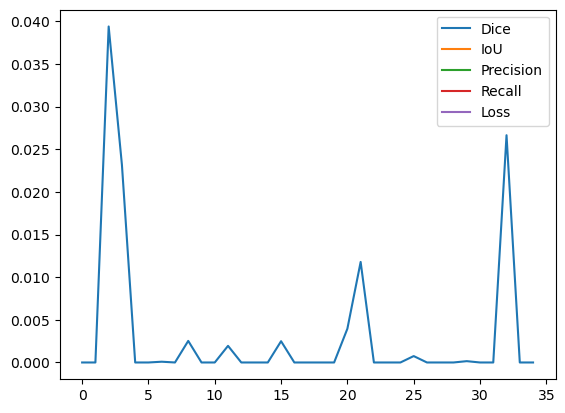

In [ ]:
plt.plot(dice_val, label = 'Dice')
plt.plot(iou_val, label = 'IoU')
plt.plot(precision_val, label = 'Precision')
plt.plot(recall_val, label = 'Recall')
plt.plot(loss_val, label = 'Loss')
plt.legend()
plt.show()

In [ ]:
no_val_iters, len(dice_val)

(0, 35)

OK


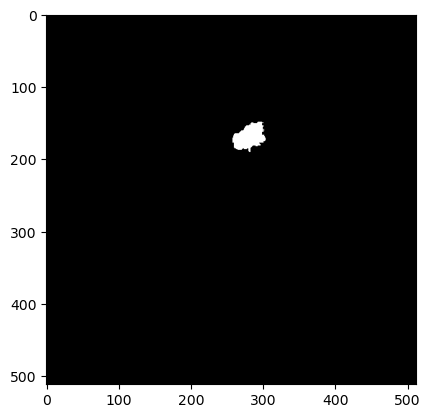

ONE HOT ENCODING TEST


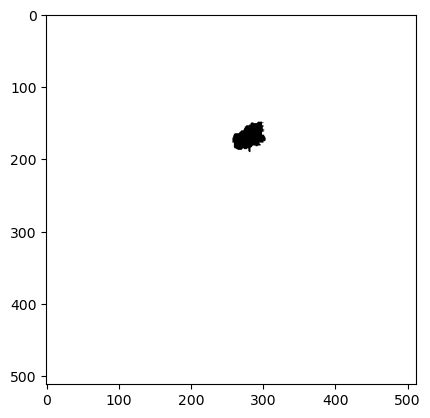

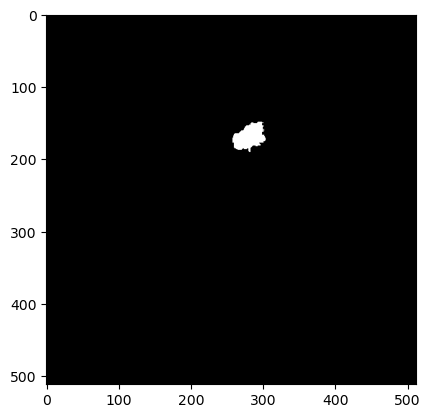

In [ ]:
# IDIOT PROOF "IT WORKS WELL" TEST - MONAI ONE HOT ENCODING MAP #

from monai.networks.utils import one_hot
# Search for a slice with a tumour

for i in range(len(msd_val_dataset)):
    if(msd_val_dataset[i][1].sum() > 3000):
        single_label = msd_val_dataset[i][1].unsqueeze(0).to('cpu')
        print("OK")
        break

# See how the label looks like
plt.imshow(single_label[0, 0, ..., 3].to('cpu').detach().numpy(), cmap = 'gray')
plt.show()


print("ONE HOT ENCODING TEST")
# See how the one-hot encoding looks like splitted in background and tumour
one_hot_lbl = one_hot(single_label, 2)
one_hot_lbl = one_hot_lbl.detach().cpu().numpy()

plt.imshow(one_hot_lbl[0, 0, ..., 3], cmap = 'gray')
plt.show()
plt.imshow(one_hot_lbl[0, 1, ..., 3], cmap = 'gray')
plt.show()

###  TEST SETUP 

In [ ]:
from seg_src.eval import generate_predictions 

In [ ]:
generate_predictions(net, msd_test_dataset, test_loader, device)

100%|██████████| 32/32 [03:54<00:00,  7.34s/it]


### NUMBER OF TRAINABLE PARAMETERS

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    # Get the total number of parameters as millions
    print(f"Total Trainable Params: {total_params/1e6:.2f} M params")
    return total_params
    
count_parameters(net)

+----------------------------------------------------------------------------+------------+
|                                  Modules                                   | Parameters |
+----------------------------------------------------------------------------+------------+
|                              module.0.weight                               |     1      |
|                               module.0.bias                                |     1      |
|                  module.1.model.0.conv.unit0.conv.weight                   |    2000    |
|                   module.1.model.0.conv.unit0.conv.bias                    |     16     |
|                  module.1.model.0.conv.unit0.adn.N.weight                  |     16     |
|                   module.1.model.0.conv.unit0.adn.N.bias                   |     16     |
|                  module.1.model.0.conv.unit0.adn.A.weight                  |     1      |
|                  module.1.model.0.conv.unit1.conv.weight                   |  

8113223